# ligistic regression

现在应该考虑列向量，Tensorflow对数据的形状非常挑剔，在numpy中，正常的一维ndarray已经被表示为列向量， 

如果我重新塑造$\mathbb{R}^n$ 为 $\mathbb{R}^{n\times1}$，它不再是列向量了，而是是1列的矩阵,那使用scipy会有麻烦。

*所以我们应该把TensorFlow的数据视为特殊情况。 我们继续使用numpy的惯例。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns            #简便画图的包，实际上是封装了matplotlib,是matplotlib的补充，不是代替
plt.style.use('fivethirtyeight')
import matplotlib.pyplot as plt
# import tensorflow as tf
from sklearn.metrics import classification_report#这个包是评价报告

# 准备数据

In [2]:
data = pd.read_csv('ex2data1.txt', names=['exam1', 'exam2', 'admitted'])
data.head()#看前五行

,exam1,exam2,admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [3]:
data.describe()

,exam1,exam2,admitted
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


### seaborn是对matplotlib的高级封装，简便画图，提供了大量参数调整图形
### 而Pandas没有太多参数调整图形；
### 两者共同点是：都是基于matplotlib的封装；
seaborn的API链接：
http://seaborn.pydata.org/api.html#style-frontend

/home/leon/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


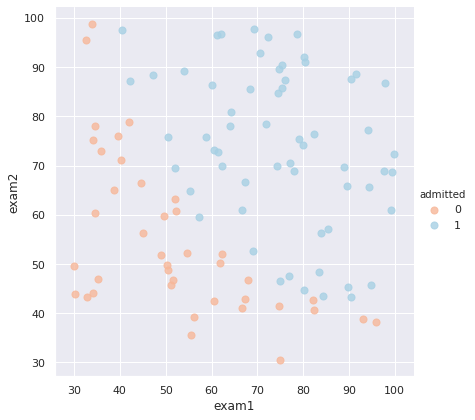

In [4]:
sns.set(context="notebook", style="darkgrid", palette=sns.color_palette("RdBu", 2),color_codes=False)

sns.lmplot('exam1', 'exam2', hue='admitted', data=data, 
           size=6, 
           fit_reg=False, 
           scatter_kws={"s": 50}
          )
plt.show()#看下数据的样子

In [5]:
def get_X(df):#读取特征
#     """
#     use concat to add intersect feature to avoid side effect
#     not efficient for big dataset though
#     """
    ones = pd.DataFrame({'ones': np.ones(len(df))})#ones是m行1列的dataframe
    data = pd.concat([ones, df], axis=1)  # 合并数据，根据列合并
    return data.iloc[:, :-1].as_matrix()  # 这个操作返回 ndarray,不是矩阵


def get_y(df):#读取标签
#     '''assume the last column is the target'''
    return np.array(df.iloc[:, -1])#df.iloc[:, -1]是指df的最后一列


def normalize_feature(df):
#     """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std())#特征缩放

In [6]:
X = get_X(data)
print(X.shape)

y = get_y(data)
print(y.shape)

(100, 3)
(100,)


/home/leon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [7]:
#X
#print(y)


## 逻辑斯蒂函数

分布函数： $F\left( x \right)=P(X\leq x)=\frac{1}{1+{{e}^{-\frac{\left(x-\mu\right)}{\gamma}}}}$ 

密度函数： $f\left( x \right)=\frac{{e}^{-\frac{x-\mu}{\gamma}}}{\gamma \left(-\frac{x-\mu}{\gamma}\right)^2} $

其图形如下：![avatar](./logistic.jpg)



## 二项逻辑斯蒂回归模型是如下条件概率分布

$P(Y = 1| x) = \frac{e^{(w*x+b)}}{1 + e^{(x*x+b)}}$

$P(Y = 0| x) = \frac{1}{1 + e^{(x*x+b)}}$

## sigmoid函数
g 代表一个常用的逻辑函数（logistic function）为S形函数（Sigmoid function），公式为： \\[g\left( z \right)=\frac{1}{1+{{e}^{-z}}}\\] 
 $h_\theta(x)=g(\theta_0+\theta_1x_1+...+\theta_nx_n)$

合起来，我们得到逻辑回归模型的假设函数： 
	\\[{{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}\\] 
  
   $h_\theta(x)$的作用是，对于给定的输入变量，根据选择的参数计算输出变量=1的可能性，即
   
   $h_\theta(x)=P(y=1|x;\theta)$
    
 代码实现：

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

### 可视化sigmod函数

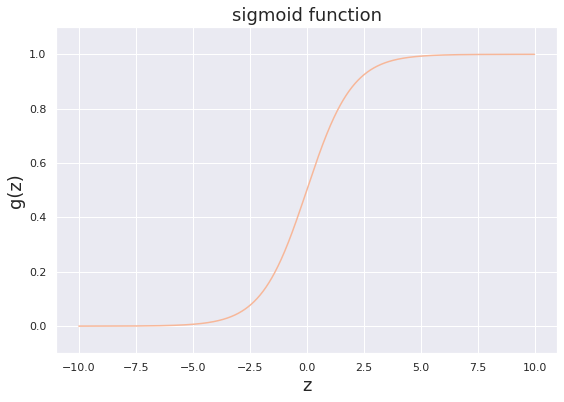

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.arange(-10, 10, step=0.01),
        sigmoid(np.arange(-10, 10, step=0.01)))
ax.set_ylim((-0.1,1.1))
ax.set_xlabel('z', fontsize=18)
ax.set_ylabel('g(z)', fontsize=18)
ax.set_title('sigmoid function', fontsize=18)
plt.show()

# cost function(代价函数)
>* $max(\ell(\theta)) = min(-\ell(\theta))$  
>* choose $-\ell(\theta)$ as the cost function

当将${{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}$带入代价函数

$J(\theta) = -\frac{1}{m}\sum\limits_{i=1}^{m}{\frac{1}{2}\left(h_\theta(x^{(i)})-y^{(i)}\right)^{2}} $

得到一个非凸函数，其图形如下：

其图形如下：![avatar](./non-convex.png)

所以，我们重新定义线性回归的代价函数为:

$J(\theta) = \frac{1}{m}\sum\limits_{i=1}^{m}{Cost\left(h_\theta(x^{(i)})-y^{(i)}\right)} $

其中:![avatar](./cost.png)

将构建的$Cost(h_\theta(x),y)$简化如下：

$Cost(h_\theta(x),y) = -y\log(h_\theta(x))-(1-y)\log(1-h_\theta(x))$

带入原代价函数得到：



$$\begin{align}
  & J\left( \theta  \right)=-\frac{1}{m}\sum\limits_{i=1}^{m}{[{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)+\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]} \\ 
 & =\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]} \\ 
\end{align}$$

我们的目标转化为求上述代价函数最小值；

In [10]:
theta=np.zeros(3) # X(m*n) so theta is n*1
theta

array([0., 0., 0.])

### 代价函数代码实现：

In [11]:
def cost(theta, X, y):
    ''' cost fn is -l(theta) for you to minimize'''
    return np.mean(-y * np.log(sigmoid(X @ theta)) - (1 - y) * np.log(1 - sigmoid(X @ theta)))

# X @ theta与X.dot(theta)等价

In [12]:
cost(theta, X, y)

0.6931471805599453

# gradient descent(梯度下降)
* 这是批量梯度下降（batch gradient descent）  
* 转化为向量化计算： $\frac{1}{m} X^T( Sigmoid(X\theta) - y )$
$$\frac{\partial J\left( \theta  \right)}{\partial {{\theta }_{j}}}=\frac{1}{m}\sum\limits_{i=1}^{m}{({{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}})x_{_{j}}^{(i)}}$$

In [13]:
def gradient(theta, X, y):
#     '''just 1 batch gradient'''
    return (1 / len(X)) * X.T @ (sigmoid(X @ theta) - y)

In [14]:
gradient(theta, X, y)

array([ -0.1       , -12.00921659, -11.26284221])

# 拟合参数
> * 这里我使用 [`scipy.optimize.minimize`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) 去寻找参数  

https://blog.csdn.net/u013063099/article/details/80964865

In [15]:
import scipy.optimize as opt

In [16]:
res = opt.minimize(fun=cost, x0=theta, args=(X, y), method='Newton-CG', jac=gradient)

In [17]:
print(res)

     fun: 0.20349770280321056
     jac: array([1.31110614e-05, 8.53917373e-04, 6.71174423e-04])
 message: 'Optimization terminated successfully.'
    nfev: 73
    nhev: 0
     nit: 29
    njev: 253
  status: 0
 success: True
       x: array([-25.15847675,   0.20620886,   0.20144849])


# 用训练集预测和验证

In [18]:
def predict(x, theta):
    prob = sigmoid(x @ theta)
    return (prob >= 0.5).astype(int)

In [19]:
final_theta = res.x
y_pred = predict(X, final_theta)
target_names = ['class 0', 'class 1']

print(classification_report(y, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.87      0.85      0.86        40
     class 1       0.90      0.92      0.91        60

    accuracy                           0.89       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.89      0.89      0.89       100



其中列表左边的一列为分类的标签名，右边support列为每个标签的出现次数．avg / total行为各列的均值（support列为总和）． 
precision recall f1-score三列分别为各个类别的精确度/召回率及 F1值．

https://blog.csdn.net/akadiao/article/details/78788864

https://blog.csdn.net/u013063099/article/details/80964865

In [20]:
print(y)

[0 0 0 1 1 0 1 1 1 1 0 0 1 1 0 1 1 0 1 1 0 1 0 0 1 1 1 0 0 0 1 1 0 1 0 0 0
 1 0 0 1 0 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 1 1 0 1 1 1
 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1]


In [21]:
print(y_pred)

[0 0 0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 0 0 1 1 0 0 0 0 1
 1 0 0 1 0 1 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 0 1 0 1 1 0 1 1 1
 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 1]


In [22]:
classification_report

<function sklearn.metrics.classification.classification_report(y_true, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False)>

# 寻找决策边界
http://stats.stackexchange.com/questions/93569/why-is-logistic-regression-a-linear-classifier
> $X \times \theta = 0$  (this is the line)

In [23]:
print(res.x) # this is final theta

[-25.15847675   0.20620886   0.20144849]


In [24]:
print(res)

     fun: 0.20349770280321056
     jac: array([1.31110614e-05, 8.53917373e-04, 6.71174423e-04])
 message: 'Optimization terminated successfully.'
    nfev: 73
    nhev: 0
     nit: 29
    njev: 253
  status: 0
 success: True
       x: array([-25.15847675,   0.20620886,   0.20144849])


In [25]:
coef = -(res.x / res.x[2])  # find the equation
print(coef)

x = np.arange(130, step=0.1)
y = coef[0] + coef[1]*x

[124.88789225  -1.02363073  -1.        ]


In [26]:
data.describe()  # find the range of x and y

,exam1,exam2,admitted
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


> you know the intercept would be around 125 for both x and y

## 解决过拟合问题
两个办法：

1.减少特征个数；

手动减少；

模型选择算法；

丢弃一些不能帮助我们正确预测的特征,可以是手工选择保留哪些特征，或者使用一些模型选择的算法来帮忙(例如PCA).

2.正则化

保留所有的特征，但是减少参数大小,量级( magnitude）。

# 3- 正则化逻辑回归

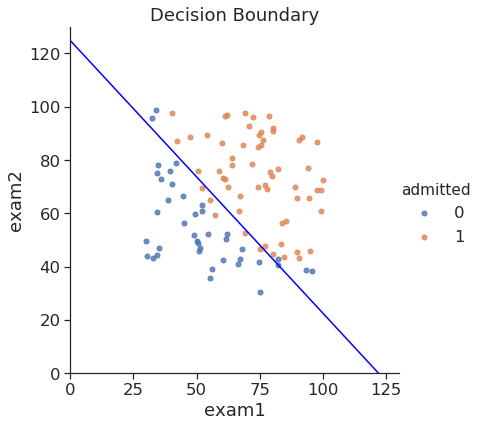

In [27]:
sns.set(context="notebook", style="ticks", font_scale=1.5,color_codes=False)

sns.lmplot('exam1', 'exam2', hue='admitted', data=data, 
           size=6, 
           fit_reg=False, 
           scatter_kws={"s": 25}
          )

plt.plot(x, y, 'blue')
plt.xlim(0, 130)
plt.ylim(0, 130)
plt.title('Decision Boundary')
plt.show()

In [28]:
df = pd.read_csv('ex2data2.txt', names=['test1', 'test2', 'accepted'])
df.head()

,test1,test2,accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


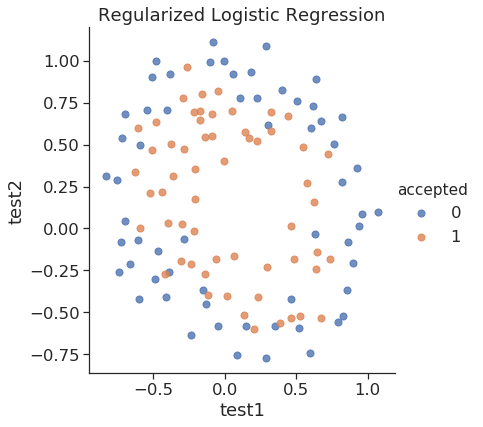

In [29]:
sns.set(context="notebook", style="ticks", font_scale=1.5)

sns.lmplot('test1', 'test2', hue='accepted', data=df, 
           size=6, 
           fit_reg=False, 
           scatter_kws={"s": 50}
          )

plt.title('Regularized Logistic Regression')
plt.show()

# feature mapping（特征映射）

在迁移学习中，基于特征映射方法是把各个领域的数据从原始高维特征空间映射到低维特征空间，在该低维空间下，源领域数据与目标领域数据拥有相同的分布。这样就可以利用低维空间表示的有标签的源领域样本数据训练分类器， 对目标测试数据进行预测。 该方法与特征选择的区别在于这些映射得到的特征不在原始的特征当中，是全新的特征。

如果样本量多，逻辑回归问题很复杂，而原始特征只有x1,x2可以用多项式创建更多的特征x1、x2、x1x2、x1^2、x2^2、... X1^nX2^n。因为更多的特征进行逻辑回归时，得到的分割线可以是任意高阶函数的形状。

polynomial expansion

```
for i in 0..i
  for p in 0..i:
    output x^(i-p) * y^p
```
<img style="float: left;" src="../img/mapped_feature.png">

In [52]:
def feature_mapping(x, y, power, as_ndarray=False):
#     """return mapped features as ndarray or dataframe"""
    # data = {}
    # # inclusive
    # for i in np.arange(power + 1):
    #     for p in np.arange(i + 1):
    #         data["f{}{}".format(i - p, p)] = np.power(x, i - p) * np.power(y, p)

    data = {"f{}{}".format(i - p, p): np.power(x, i - p) * np.power(y, p)
                for i in np.arange(power + 1)
                for p in np.arange(i + 1)
            }

    if as_ndarray:
        return pd.DataFrame(data).as_matrix()
    else:
        return pd.DataFrame(data)

In [55]:
x1 = np.array(df.test1)
x2 = np.array(df.test2)
print(x1.shape)
print(x2.shape)

(118,)
(118,)


In [54]:
data = feature_mapping(x1, x2, power=6)
print(data.shape)
data.head()

(118, 28)


,f00,f10,f01,f20,f11,f02,f30,f21,f12,f03,...,f23,f14,f05,f60,f51,f42,f33,f24,f15,f06
0,1.0,0.051267,0.69956,0.002628,0.035864,0.489384,0.000135,0.001839,0.025089,0.342354,...,0.000900,0.012278,0.167542,1.815630e-08,2.477505e-07,0.000003,0.000046,0.000629,0.008589,0.117206
1,1.0,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,0.321335,...,0.002764,-0.020412,0.150752,6.362953e-07,-4.699318e-06,0.000035,-0.000256,0.001893,-0.013981,0.103256
2,1.0,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,0.331733,...,0.015151,-0.049077,0.158970,9.526844e-05,-3.085938e-04,0.001000,-0.003238,0.010488,-0.033973,0.110047
3,1.0,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,0.126650,...,0.017810,-0.023851,0.031940,2.780914e-03,-3.724126e-03,0.004987,-0.006679,0.008944,-0.011978,0.016040
4,1.0,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,0.100960,...,0.026596,-0.024128,0.021890,1.827990e-02,-1.658422e-02,0.015046,-0.013650,0.012384,-0.011235,0.010193


In [56]:
data.describe()

,f00,f10,f01,f20,f11,f02,f30,f21,f12,f03,...,f23,f14,f05,f60,f51,f42,f33,f24,f15,f06
count,118.0,118.000000,118.000000,118.000000,118.000000,118.000000,1.180000e+02,118.000000,118.000000,118.000000,...,118.000000,1.180000e+02,118.000000,1.180000e+02,118.000000,1.180000e+02,118.000000,1.180000e+02,118.000000,1.180000e+02
mean,1.0,0.054779,0.183102,0.247575,-0.025472,0.301370,5.983333e-02,0.030682,0.015483,0.142350,...,0.018278,4.089084e-03,0.115710,7.837118e-02,-0.000703,1.893340e-02,-0.001705,2.259170e-02,-0.006302,1.257256e-01
std,0.0,0.496654,0.519743,0.248532,0.224075,0.284536,2.746459e-01,0.134706,0.150143,0.326134,...,0.058513,9.993907e-02,0.299092,1.938621e-01,0.058271,3.430092e-02,0.037443,4.346935e-02,0.090621,2.964416e-01
min,1.0,-0.830070,-0.769740,0.000040,-0.484096,0.000026,-5.719317e-01,-0.358121,-0.483743,-0.456071,...,-0.142660,-4.830370e-01,-0.270222,6.472253e-14,-0.203971,2.577297e-10,-0.113448,2.418097e-10,-0.482684,1.795116e-14
25%,1.0,-0.372120,-0.254385,0.043243,-0.178209,0.061086,-5.155632e-02,-0.023672,-0.042980,-0.016492,...,-0.001400,-7.449462e-03,-0.001072,8.086369e-05,-0.006381,1.258285e-04,-0.005749,3.528590e-04,-0.016662,2.298277e-04
50%,1.0,-0.006336,0.213455,0.165397,-0.016521,0.252195,-2.544062e-07,0.006603,-0.000039,0.009734,...,0.001026,-8.972096e-09,0.000444,4.527344e-03,-0.000004,3.387050e-03,-0.000005,3.921378e-03,-0.000020,1.604015e-02
75%,1.0,0.478970,0.646562,0.389925,0.100795,0.464189,1.099616e-01,0.086392,0.079510,0.270310,...,0.021148,2.751341e-02,0.113020,5.932959e-02,0.002104,2.090875e-02,0.001024,2.103622e-02,0.001289,1.001215e-01
max,1.0,1.070900,1.108900,1.146827,0.568307,1.229659,1.228137e+00,0.449251,0.505577,1.363569,...,0.287323,4.012965e-01,1.676725,1.508320e+00,0.250577,2.018260e-01,0.183548,2.556084e-01,0.436209,1.859321e+00


# regularized cost（正则化代价函数）
$$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}+\frac{\lambda }{2m}\sum\limits_{j=1}^{n}{\theta _{j}^{2}}$$

In [34]:
theta = np.zeros(data.shape[1])
X = feature_mapping(x1, x2, power=6, as_ndarray=True)
print(X.shape)

y = get_y(df)
print(y.shape)

(118, 28)
(118,)


/home/leon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


In [36]:
def regularized_cost(theta, X, y, l=1):
#     '''you don't penalize theta_0'''
    theta_j1_to_n = theta[1:]
    regularized_term = (l / (2 * len(X))) * np.power(theta_j1_to_n, 2).sum()

    return cost(theta, X, y) + regularized_term
#正则化代价函数

In [37]:
regularized_cost(theta, X, y, l=1)

0.6931471805599454

this is the same as the not regularized cost because we init theta as zeros...
因为我们设置theta为0，所以这个正则化代价函数与代价函数的值相同

# regularized gradient(正则化梯度)
$$\frac{\partial J\left( \theta  \right)}{\partial {{\theta }_{j}}}=\left( \frac{1}{m}\sum\limits_{i=1}^{m}{\left( {{h}_{\theta }}\left( {{x}^{\left( i \right)}} \right)-{{y}^{\left( i \right)}} \right)} \right)+\frac{\lambda }{m}{{\theta }_{j}}\text{ }\text{             for  j}\ge \text{1}$$

In [38]:
def regularized_gradient(theta, X, y, l=1):
#     '''still, leave theta_0 alone'''
    theta_j1_to_n = theta[1:]
    regularized_theta = (l / len(X)) * theta_j1_to_n

    # by doing this, no offset is on theta_0
    regularized_term = np.concatenate([np.array([0]), regularized_theta])

    return gradient(theta, X, y) + regularized_term

In [39]:
regularized_gradient(theta, X, y)

array([8.47457627e-03, 1.87880932e-02, 7.77711864e-05, 5.03446395e-02,
       1.15013308e-02, 3.76648474e-02, 1.83559872e-02, 7.32393391e-03,
       8.19244468e-03, 2.34764889e-02, 3.93486234e-02, 2.23923907e-03,
       1.28600503e-02, 3.09593720e-03, 3.93028171e-02, 1.99707467e-02,
       4.32983232e-03, 3.38643902e-03, 5.83822078e-03, 4.47629067e-03,
       3.10079849e-02, 3.10312442e-02, 1.09740238e-03, 6.31570797e-03,
       4.08503006e-04, 7.26504316e-03, 1.37646175e-03, 3.87936363e-02])

# 拟合参数

In [40]:
import scipy.optimize as opt

In [41]:
print('init cost = {}'.format(regularized_cost(theta, X, y)))

res = opt.minimize(fun=regularized_cost, x0=theta, args=(X, y), method='Newton-CG', jac=regularized_gradient)
res

init cost = 0.6931471805599454


     fun: 0.529002729712811
     jac: array([-2.78076901e-07,  1.59657881e-08, -1.63419059e-09, -1.32540891e-07,
        5.36446715e-08, -3.53593833e-09,  3.26587394e-08, -3.77629131e-08,
       -1.01825433e-08,  2.04139284e-08, -1.24857089e-07, -2.60850256e-09,
       -7.10679540e-08,  7.64905091e-09, -3.00529719e-10,  1.60394712e-08,
       -1.65345396e-08, -1.83851007e-08, -1.98688605e-08, -2.57604572e-09,
        3.15506381e-08, -6.30775028e-08, -3.24636753e-09, -3.41857296e-08,
       -9.53725294e-09, -2.65050518e-08, -5.31889282e-09,  1.93297994e-08])
 message: 'Optimization terminated successfully.'
    nfev: 7
    nhev: 0
     nit: 6
    njev: 68
  status: 0
 success: True
       x: array([ 1.27273903,  0.62527034,  1.18108994, -2.0199586 , -0.91742323,
       -1.43166395,  0.12400732, -0.36553439, -0.35724021, -0.17513056,
       -1.45815766, -0.05098993, -0.61555683, -0.27470638, -1.19281759,
       -0.2421873 , -0.20600595, -0.04473162, -0.27778488, -0.29537811,
       -0.45

# 预测

In [42]:
final_theta = res.x
y_pred = predict(X, final_theta)

print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82        60
           1       0.78      0.91      0.84        58

    accuracy                           0.83       118
   macro avg       0.84      0.83      0.83       118
weighted avg       0.84      0.83      0.83       118



# 使用不同的 $\lambda$ （这个是常数）
# 画出决策边界
* 我们找到所有满足 $X\times \theta = 0$ 的x
* instead of solving polynomial equation, just create a coridate x,y grid that is dense enough, and find all those $X\times \theta$ that is close enough to 0, then plot them

In [43]:
def draw_boundary(power, l):
#     """
#     power: polynomial power for mapped feature
#     l: lambda constant
#     """
    density = 1000
    threshhold = 2 * 10**-3

    final_theta = feature_mapped_logistic_regression(power, l)
    x, y = find_decision_boundary(density, power, final_theta, threshhold)

    df = pd.read_csv('ex2data2.txt', names=['test1', 'test2', 'accepted'])
    sns.lmplot('test1', 'test2', hue='accepted', data=df, size=6, fit_reg=False, scatter_kws={"s": 100})

    plt.scatter(x, y, c='R', s=10)
    plt.title('Decision boundary')
    plt.show()

In [44]:
def feature_mapped_logistic_regression(power, l):
#     """for drawing purpose only.. not a well generealize logistic regression
#     power: int
#         raise x1, x2 to polynomial power
#     l: int
#         lambda constant for regularization term
#     """
    df = pd.read_csv('ex2data2.txt', names=['test1', 'test2', 'accepted'])
    x1 = np.array(df.test1)
    x2 = np.array(df.test2)
    y = get_y(df)

    X = feature_mapping(x1, x2, power, as_ndarray=True)
    theta = np.zeros(X.shape[1])

    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, l),
                       method='TNC',
                       jac=regularized_gradient)
    final_theta = res.x

    return final_theta

In [64]:
def find_decision_boundary(density, power, theta, threshhold):
    t1 = np.linspace(-1, 1.5, density)
    t2 = np.linspace(-1, 1.5, density)

    cordinates = [(x, y) for x in t1 for y in t2]
    x_cord, y_cord = zip(*cordinates)
    mapped_cord = feature_mapping(x_cord, y_cord, power)  # this is a dataframe

    inner_product = mapped_cord.as_matrix() @ theta

    decision = mapped_cord[np.abs(inner_product) < threshhold]

    print(decision.shape)
    return decision.f10, decision.f01   #返回x1,x2
#寻找决策边界函数

/home/leon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/home/leon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


(544, 28)


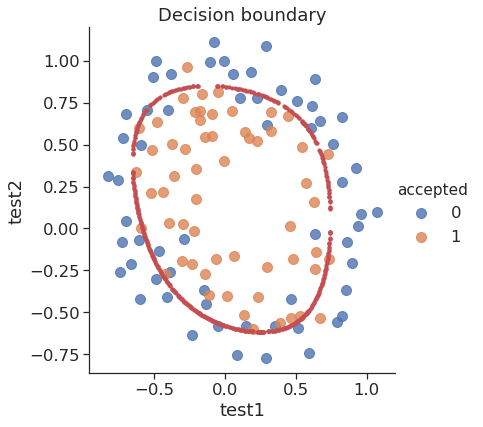

In [65]:
draw_boundary(power=6, l=1)#lambda=1

/home/leon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/home/leon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


(252, 28)


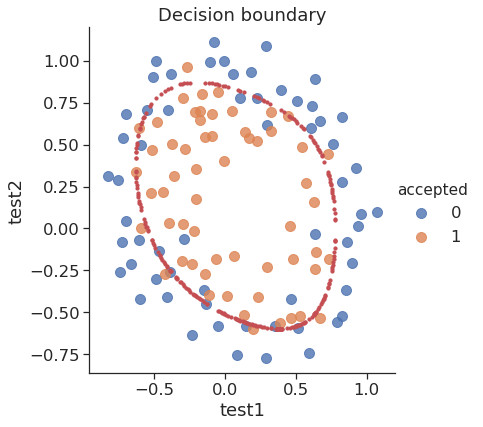

In [66]:
draw_boundary(power=6, l=0.1)  # no regularization, over fitting，#lambda=0,没有正则化，过拟合了

/home/leon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/home/leon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


(26664, 28)


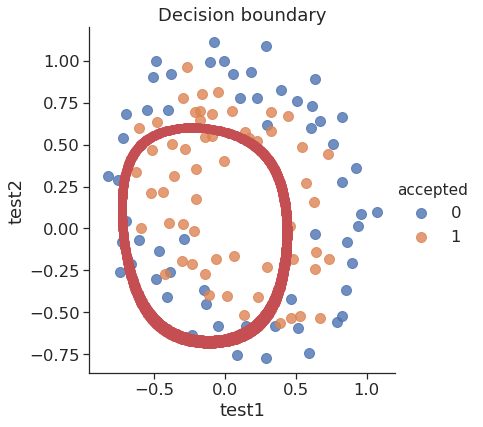

In [67]:
draw_boundary(power=6, l=100)  # underfitting，#lambda=100,欠拟合